# Part 1: Data preprocessing

# 1, Package preparation

In [1]:
#! pip install missingno
#! pip install geopy
# !pip install geopandas
# !pip install geoplot   # need conda install -c conda-forge cartopy 
# !pip install shapely
import numpy as np
import pandas as pd
import geopy
np.set_printoptions(threshold=np.inf)
from scipy import stats
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import plt
%pylab inline
import missingno as msno 
import warnings # ignore the warnings
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
import geoplot as gplt
from string import ascii_letters
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# 2, Data load

In [2]:
# upload the raw database
file = pd.read_csv('Housing_info.csv')
file.shape

(9189, 64)

##### Delete meaningless columns

In [3]:
# delete meaningless columns
housing=file.iloc[:,0:51]
housing=housing.iloc[:,1:]
housing.head(5)

,user_id,country_id,city_id,city_name_input,state_name_input,community_id,zip_code,house_type_id,bedroom_count,bathroom_count,...,dynamic_link,area,rent_type_id,video_url,publisher_identity,rent_duration,deposit_amount,language,listing_key,identity
0,41,0,11,New York,NY,NaN,10469,1,1,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0
1,41,11,11,New York,NY,NaN,11419,1,1,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0
2,41,11,11,New York,NY,NaN,10128,1,1,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0
3,41,0,401,Lynnwood,Washington,NaN,98087,21,2,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0
4,41,0,21,Seattle,Washington,NaN,98109,1,1,1,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0


##### Delete all NaN columns and rows

In [4]:
# delete columns with all NaN
housing1 = housing.loc[:,~housing.isnull().all()]
# delete rows with all NaN
housing2 = housing1[~housing1.isnull().all(axis=1)]
housing2.shape

(9150, 50)

The orginal data shape is (9189, 64), after dropping columns/rows with all NA, the data now is 9150 rows and 50 columns

# 3, Data Cleaning
## 3.1 Missing values primary analysis

###### Missing Values Description Overview

In [5]:
missing_df = housing.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.sort_values(by='missing_count')
missing_df['missing_percentage'] = missing_df['missing_count']/len(housing)
# missing_df

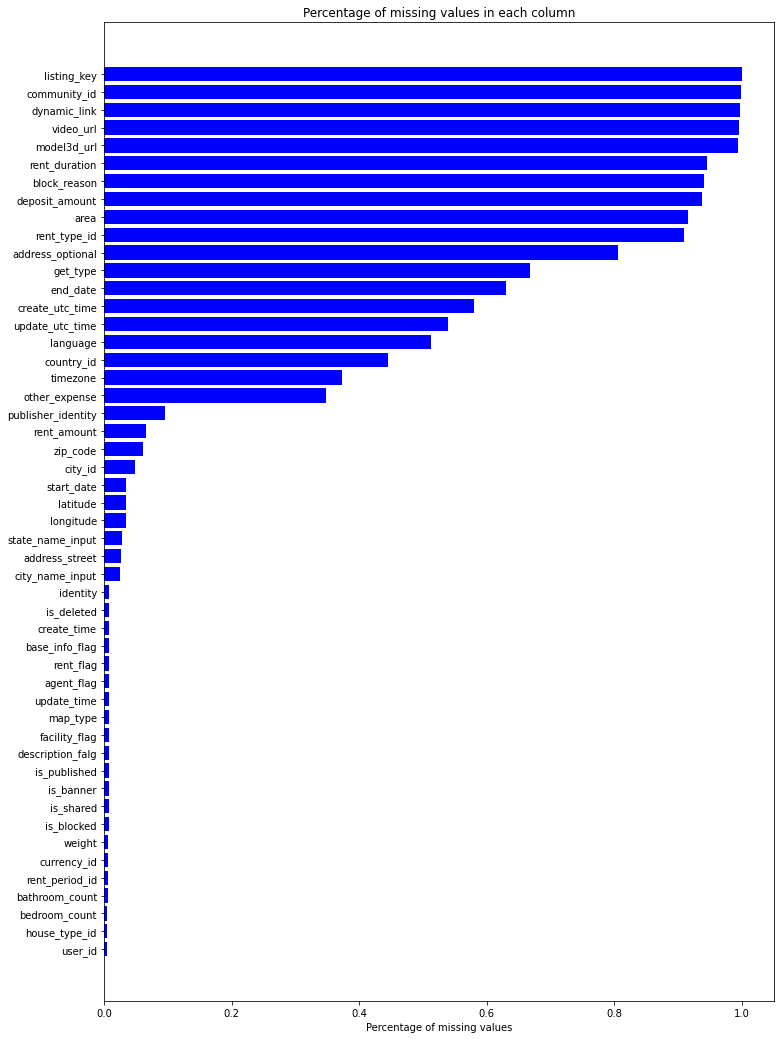

In [6]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_percentage.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Percentage of missing values")
ax.set_title("Percentage of missing values in each column")
plt.show()

## 3.2 Odd values anlaysis and modification
##### Cleaning odd rows with invalid User_ID
User Id is the key to indicate whether the record is unique or not, so we need to make sure that each user Id is a valid one. 

In [7]:
# delete some odd rows, depending on 'use_id'
print(sort(housing2['user_id'].unique()))

['  欢迎大家随时预约看房！' ' End Unit' ' Water/Sewer. "' ' and Yoga Studio"'
 ' kitchen island with Insinkerator' ' 各種中式泰式越式韓式印式馬式川式粵式台式餐廳' ' 從事金融'
 ' 租房\\"。' '0' '1' '100002' '100021' '100081' '100141' '100161' '100182'
 '10031' '100411' '100552' '100571' '100611' '100681' '100741' '10091'
 '101' '10121' '101231' '101271' '101291' '10131' '101441' '101461'
 '101571' '101651' '101652' '101801' '101951' '102' '102021' '102052'
 '102071' '102332' '102362' '102491' '102492' '102502' '102712' '102811'
 '102851' '102872' '103002' '103012' '103021' '103162' '103202' '103241'
 '103242' '103262' '103312' '10351' '103612' '10371' '103741' '103751'
 '103771' '103901' '103952' '103982' '104121' '104161' '104212' '104231'
 '104242' '10431' '10441' '10451' '104512' '104562' '104762' '104822'
 '104921' '104922' '104951' '104991' '105001' '105101' '105291' '105301'
 '105321' '105481' '105541' '10591' '105971' '105972' '105982' '105991'
 '106062' '106201' '106361' '10641' '106482' '10651' '106572' '106581'
 '10

It is clear that some values are not normal. User Id should be made up with pure decimal numbers.   
Then, we store these weird values into a list, and we get rid of those matched rows since they are not valid

In [8]:
# potential odd values
housing2['user_id'][housing2['user_id'].apply(lambda x: x.isdecimal()) == False]

898                                 租房\"。
899                   2019-03-28 11:50:10
4220                          欢迎大家随时预约看房！
4223                  2019-05-22 14:15:14
4404                  2019-06-11 15:53:41
6783                             End Unit
7038                             End Unit
7039                       Water/Sewer. "
7305                  2020-08-25 09:11:55
8509            20mins車程到JFK機場 ✈️🧳(疫情回不了國
8511               各種中式泰式越式韓式印式馬式川式粵式台式餐廳
8512                                 從事金融
8796     kitchen island with Insinkerator
8799                     and Yoga Studio"
Name: user_id, dtype: object

In [9]:
useidoddvalue = ['  欢迎大家随时预约看房！','2019-06-11 15:53:41',' Water/Sewer. "','2020-08-25 09:11:55',
                 ' End Unit','2019-05-22 14:15:14', '2019-03-28 11:50:10',
                 '20mins車程到JFK機場 ✈️🧳(疫情回不了國', ' 各種中式泰式越式韓式印式馬式川式粵式台式餐廳', ' 從事金融',
                 ' kitchen island with Insinkerator', ' and Yoga Studio"',' 租房\\"。','2019-03-28 11:50:10']
useidoddindex = []
housing2.reset_index(drop=True, inplace=True)
for i in range(len(housing2)):
    #print(i)
    if housing2.iloc[i, :]['user_id'] in useidoddvalue:
        useidoddindex.append(i)
# Show those rows we deletes and check whether it is reasonable to delete
housing2.loc[useidoddindex,:]

,user_id,country_id,city_id,city_name_input,state_name_input,community_id,zip_code,house_type_id,bedroom_count,bathroom_count,...,dynamic_link,area,rent_type_id,video_url,publisher_identity,rent_duration,deposit_amount,language,listing_key,identity
893,"租房\""。",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
894,2019-03-28 11:50:10,NaN,NaN,NaN,1,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4213,欢迎大家随时预约看房！,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4214,2019-05-22 14:15:14,NaN,NaN,America/New_York,1,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4390,2019-06-11 15:53:41,NaN,NaN,America/New_York,1,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6755,End Unit,Insulated Windows,Master Bath,Vaulted Ceilings,"Walk-in Closet""",0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7009,End Unit,Insulated Windows,Master Bath,Vaulted Ceilings,Walk-in Closet Common Property Features: Elev...,Fire Sprinklers,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7010,"Water/Sewer. """,0,NaN,0,0,0,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7276,2020-08-25 09:11:55,2020-06-04 23:43:39,2020-08-25 16:11:55,America/Los_Angeles,1,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8477,20mins車程到JFK機場 ✈️🧳(疫情回不了國,在美國境內散散心也是必須的!),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that these records are indeed with a lot of missing values, or unmatching meaningless information. Therefore, we can just drop them

In [10]:
# Drop those rows
housing3 = housing2.drop(useidoddindex)
housing3['user_id'].unique()
housing3.reset_index(drop=True, inplace=True)

## 3.3 Filling in Geo information
The reason we are using the geo information is that we need to select out the data which country is the United States. We are only studying on the rent in the U.S.. However, since the country ID is missing about 44.29%, it's hard to use it as a filtering qriteria. Therefore, we choose to use longtitude and latitude, which are only missing 2.95%, to extract the geographic information by using the Geopy library. The Geopy library will generate the Country, City and zipcode according to the longtitude and latitude. This process will also help us to fill in some missing values in the variables of city_name_input, state_name_input, timezone and zipcode 

In [11]:
# we need to both longtitude and latitude to use the geopy function 
# we only choose those with non-nan longitude and latitude
housing4 = housing3[~(housing3['longitude'].isnull() |housing3['latitude'].isnull())]

Also, similar to what we did with the user id, we need to find out if there is any weird record in the longtitude or latitude columns. 
The values should be able to convert to float, otherwise, we need to be careful of those which can't be converted. 

In [12]:
# find all improper longitude and latitude data
def checktype(x):
    try:
        float(x) 
        res = True
    except : 
        res = False
    return res

housing4['longitude'][housing4['longitude'].apply(lambda x: checktype(x)) == False]

454     2017-12-25 15:18:56
633     2018-01-16 16:19:45
894     2018-02-25 23:43:27
1586    2018-06-09 11:49:30
5170    2019-10-04 18:50:02
8468    2020-10-27 05:05:19
Name: longitude, dtype: object

In [13]:
housing4['latitude'][housing4['latitude'].apply(lambda x: checktype(x)) == False]

454     2018-03-04 15:55:37
633     2018-04-08 16:11:30
894     2019-03-06 23:49:02
1586    2018-06-09 11:59:53
5170    2019-10-04 19:04:05
8468    2020-10-27 05:12:50
Name: latitude, dtype: object

We could see that some date type objects are mixed into the longtitude and latitude values. We need to drop these rows

In [14]:
lloddvalue = ['2017-12-25 15:18:56', '2018-01-16 16:19:45','2018-02-25 23:43:27','2018-06-09 11:49:30','2020-10-27 05:05:19']
lloddindex = []
housing4.reset_index(drop=True, inplace=True)
for i in range(len(housing4)):
    #print(i)
    if housing4.iloc[i, :]['longitude'] in lloddvalue:
        lloddindex.append(i)

housing5 = housing4.drop(lloddindex)

# housing5['longitude'].unique()
housing5.reset_index(drop=True, inplace=True)

##### Geopy
Now, we are creating four new columns to record the geographic information we gained from longtitude and latitude. These columns can also replace the city_name_input, state_name_input and zipcode columns

In [15]:
'''Here are the codes for geo part, we just comment it because it would take a long time to interate
# We have saved the result in the following cvs file.'''

## initiazlie four new columns
# housing5['Country_geo'] = 0
# housing5['City_geo'] = 0
# housing5['State_geo'] = 0
# housing5['Postcode_geo'] = 0
# geolocator = Nominatim(user_agent = 'user_agent')

#for i in range(len(housing5)):
#    Latitude = housing5.iloc[i, :]['latitude']
#    Longitude = housing5.iloc[i, :]['longitude']
#    location = geolocator.reverse(Latitude+","+Longitude) 
#    address = location.raw['address'] 
#    housing5['City_geo'][i] = address.get('city', '') 
#    housing5['State_geo'][i] = address.get('state', '') 
#    housing5['Country_geo'][i] = address.get('country', '') 
#    # code = address.get('country_code') 
#    housing5['Postcode_geo'][i] = address.get('postcode') 
    
## Drop odd rows with meaningless location info (middle in the ocean)
#lloddindex2 = [1087, 1796, 1836, 1844, 2404, 2423, 2478, 4626, 5134, 5786, 8660]
##print(len(housing5))
#housing6 = housing5.drop(lloddindex2)
##print(len(housing6))
#housing6.reset_index(drop=True, inplace=True)



'Here are the codes for geo part, we just comment it because it would take a long time to interate\n# We have saved the result in the following cvs file.'

#### Store the clearned file into a new csv
Since the geopy function takes a long time to iterate through the dataframe, we saved/cached this new dataframe into a new csv file for further data processing and modelling. 

In [16]:
# housing6.to_csv("Housing_info_withgeo.csv",index=False,sep=',')

##### Choose only US data

Filter by country = "United States". 
Now we have the new dataset, we only need the data which records the rent in the United States. 

In [17]:
housing7 = pd.read_csv('Housing_info_withgeo.csv')
UShousing = housing7[housing7['Country_geo'] == 'United States']
UShousing.shape

(8206, 54)

##### Geographic information complementation
We could see that geopy sometimes generate NA values for city names, whereas the city_name_input luckily has it for filling. And sometimes the city_name_inputs are in Chinese or NA, but we also luckily to have the city_geo which generated by geopy to fill those in. 

##### Fill in the Known missing value of Geographic information

In [18]:
UShousing1 = UShousing

In [19]:
UShousing1.loc[(UShousing1['City_geo'].isnull() == True) & (UShousing1['city_name_input'].isnull() == False),"city_name_input"].unique()

array(['Lynnwood', 'Daly City', 'Kirkland', 'Schererville', 'Bethpage',
       'Westbury', 'Orlando', 'Mercer Island', 'Brookline', 'Kenmore',
       'Seattle', '纽卡斯尔', 'Auburn', 'West Lafayette', 'Davis', 'Bothell',
       'Redmond', 'Seattle ', 'Dublin', 'East Palo Alto', 'San Gabriel',
       'Pleasant Hill', 'San Jose', 'Rochester', 'Issaquah', '西拉法叶',
       'Sammamish', 'Hoboken', 'West Lafayette ', 'Tukwila',
       'West Covina', 'Waltham', 'Alhambra', 'Diamond Bar', 'Malden',
       'Castro Valley', 'Somerville', 'Moore', 'Rowland Heights',
       'Union City', 'Santee', 'Edmonds', 'Arcadia', 'Medford',
       'Harrison', 'San Leandro', 'San Lorenzo', 'Rosemead',
       'Chino Hills', 'Evanston', 'Union city', 'West New York',
       'Emeryville', 'Burien', 'Amherst', 'Placentia', 'Las Vegas',
       'San Diego', 'Puyallup', 'Monterey Park', 'Walnut', '洛杉矶',
       'Richmond', 'Woodinville', 'Kent ', 'Floral Park', 'Mukilteo',
       'Elmwood Park', 'El Cerrito', 'Belmont', 'F

In [20]:
UShousing1.loc[(UShousing1['City_geo'].isnull() == True) & (UShousing1['city_name_input'].isnull() == False),
               "City_geo"]=UShousing1.loc[(UShousing1['City_geo'].isnull() == True) & (UShousing1['city_name_input'].isnull() == False),
                                          "city_name_input"]



There are Chinese, so we may need to hardcode them into English 

In [21]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
        res = True
    except UnicodeDecodeError:
        res =  False 
    return res
    

In [22]:
# Get the celles with Chinese character
UShousing1.loc[UShousing1.loc[:,'City_geo'].apply(lambda x: isEnglish(str(x))) == False,"City_geo"].unique()

array(['纽卡斯尔', '西拉法叶', '洛杉矶', '旧金山', '核桃市', '阿苏萨', 'Kirkland 柯克兰', '波士顿',
       '雷德蒙德', '西雅图', '米尔克里克', '天普市', '达勒姆', '柯克兰', '戴利城', '伊萨夸', '巴尔的摩市',
       '希尔斯伯勒', '林恩伍德', '奇诺岗', '阿罕布拉', '罗兰高地', '蒙市', '林伍德', '戴维斯', '柔似蜜',
       '多伦多', '洛杉矶 upland', '阿卡迪亚', '迈阿密', '帝利市', '纽约曼哈顿', '博塞尔'],
      dtype=object)

In [23]:
di = {'纽卡斯尔': "Newcastle", '西拉法叶': "West Lafayette",'洛杉矶':"Los Angeles", '旧金山': "San Fransisco", '核桃市' : "Walnut City",
      '阿苏萨' :'Asusa', 'Kirkland 柯克兰' : "Kirkland", '波士顿' : "Boston",
       '雷德蒙德':'Redmond', '西雅图' : 'Seattle', '米尔克里克' :'Mill creek', '天普市' :'Temple City', '达勒姆' :'Durham', 
      '柯克兰' : 'Kirkland', '戴利城' : 'Daly City', '伊萨夸':'Isakwa', '巴尔的摩市':"Baltimore",
       '希尔斯伯勒':'Hillsboro', '林恩伍德':'Lynnwood', '奇诺岗':'Chino hills', '阿罕布拉':'Alhambra', '罗兰高地':'Roland Heights', 
      '蒙市':'Monterey park', '林伍德':'Linwood', '戴维斯':'Davis', '柔似蜜':'Rosemead',
       '多伦多' :"Toronto", '洛杉矶 upland':"Los Angeles", '阿卡迪亚' :'Arcadia', '迈阿密' :'Miami', '帝利市' :'Dili', 
      '纽约曼哈顿':'Manhattan','博塞尔':'Bothell' }

UShousing1.replace({"City_geo": di},inplace = True)
# UShousing1.loc[:,'City_geo'].unique()

Fill-in the missing Postcode_geo from Zipcode

In [24]:
UShousing1.loc[(UShousing1['Postcode_geo'].isnull() == True) & (UShousing1['zip_code'].isnull() == False),"zip_code"].unique()

array(['92127', '98109', '11355', '98101', '98052', '1000111', '97531',
       '91709', '2134', '90005', '94523', '2115', '10009', '98087',
       '98075', '92122', '98105', '10025', '48105', '10018', '2', '98103',
       '64803', '98004', '98005'], dtype=object)

In [25]:
UShousing1.loc[(UShousing1['Postcode_geo'].isnull() == True) & (UShousing1['zip_code'].isnull() == False),
               "Postcode_geo"] = UShousing1.loc[(UShousing1['Postcode_geo'].isnull() == True) & (UShousing1['zip_code'].isnull() == False),
               "zip_code"] 


Fill in the State_geo with State_name_input

In [26]:
UShousing1.loc[(UShousing1['State_geo'].isnull() == True) & (UShousing1['state_name_input'].isnull() == False),"state_name_input"].unique()

array(['纽约'], dtype=object)

In [27]:
UShousing1.loc[(UShousing1['State_geo'].isnull() == True) & (UShousing1['state_name_input'].isnull() == False),"State_geo"] = "New York"

In [28]:
UShousing1 = UShousing1.drop(['city_id','country_id','city_name_input','zip_code','state_name_input','address_street','other_expense'], axis=1)
UShousing1.head(10)

,user_id,community_id,house_type_id,bedroom_count,bathroom_count,longitude,latitude,address_optional,start_date,end_date,...,publisher_identity,rent_duration,deposit_amount,language,listing_key,identity,Country_geo,City_geo,State_geo,Postcode_geo
0,41,NaN,1.0,1.0,1.0,-73.857997,40.862775,罗切斯特大学,2017-09-25,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,New York,New York,10467.0
1,41,NaN,1.0,1.0,1.0,-73.827866,40.693742,Elmhurst地铁站附近,2017-09-25,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,New York,New York,11419.0
2,41,NaN,1.0,1.0,1.0,-73.951277,40.780365,哥大附近111街 Broadway & Amsterdam直接,2017-09-25,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,New York,New York,10128.0
3,41,NaN,21.0,2.0,1.0,-122.269401,47.848989,NaN,2017-10-01,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,Lynnwood,Washington,98087.0
4,41,NaN,1.0,1.0,1.0,-122.356307,47.647601,NaN,2017-10-01,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,Seattle,Washington,98109.0
18,101,NaN,1.0,1.0,1.0,-84.439526,33.817098,1505,2017-09-25,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,Atlanta,Georgia,30318.0
19,131,NaN,1.0,2.0,1.9,-122.297481,47.722173,NaN,2017-06-25,2017-10-25,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,Seattle,Washington,98125.0
29,271,NaN,21.0,6.0,4.0,-94.717234,38.921708,NaN,2017-09-29,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,Overland Park,Kansas,66210.0
42,1261,NaN,31.0,1.0,1.0,-122.415487,37.704823,NaN,2017-10-25,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,Daly City,California,94014
43,1261,NaN,31.0,1.0,1.0,-122.415470,37.704703,NaN,2017-10-25,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,United States,Daly City,California,94014


# 3.3 Other data cleaning for each column

##### Drop the the columns that have more than 55% missing values
We will try to fill in the missing valus for those columns that have less than 50% missing values.

In [29]:
missing_df = UShousing1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
#missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df['missing_percentage'] = missing_df['missing_count']/len(UShousing1)
missing_df

,column_name,missing_count,missing_percentage
0,user_id,0,0.000000
43,Country_geo,0,0.000000
3,bedroom_count,0,0.000000
4,bathroom_count,0,0.000000
5,longitude,0,0.000000
6,latitude,0,0.000000
45,State_geo,0,0.000000
44,City_geo,1,0.000122
46,Postcode_geo,2,0.000244
2,house_type_id,2,0.000244


In [30]:
UShousing1 = UShousing1.drop(['create_utc_time','end_date','get_type', 'address_optional', 
                'rent_type_id','area','deposit_amount','block_reason', 'model3d_url', 
                'video_url','dynamic_link','listing_key','community_id'], axis=1)
UShousing1.reset_index(drop=True, inplace=True)
UShousing1.head(10)

,user_id,house_type_id,bedroom_count,bathroom_count,longitude,latitude,start_date,rent_amount,rent_period_id,currency_id,...,timezone,map_type,publisher_identity,rent_duration,language,identity,Country_geo,City_geo,State_geo,Postcode_geo
0,41,1.0,1.0,1.0,-73.857997,40.862775,2017-09-25,1500.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,New York,New York,10467.0
1,41,1.0,1.0,1.0,-73.827866,40.693742,2017-09-25,900.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,New York,New York,11419.0
2,41,1.0,1.0,1.0,-73.951277,40.780365,2017-09-25,45.0,1.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,New York,New York,10128.0
3,41,21.0,2.0,1.0,-122.269401,47.848989,2017-10-01,2040.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,Lynnwood,Washington,98087.0
4,41,1.0,1.0,1.0,-122.356307,47.647601,2017-10-01,1000.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,Seattle,Washington,98109.0
5,101,1.0,1.0,1.0,-84.439526,33.817098,2017-09-25,500.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,Atlanta,Georgia,30318.0
6,131,1.0,2.0,1.9,-122.297481,47.722173,2017-06-25,5888.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,Seattle,Washington,98125.0
7,271,21.0,6.0,4.0,-94.717234,38.921708,2017-09-29,600.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,Overland Park,Kansas,66210.0
8,1261,31.0,1.0,1.0,-122.415487,37.704823,2017-10-25,0.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,Daly City,California,94014
9,1261,31.0,1.0,1.0,-122.415470,37.704703,2017-10-25,1200.0,2.0,1.0,...,NaN,1,0.0,NaN,NaN,0.0,United States,Daly City,California,94014


##### Data cleaning for the language column
Given the known information, we know that 'zh' represents for Chinese, and 'en' represents for "English". But other than these two values, other inputs such as date, "so", "ja" and etc. are meaningless and will be replaced by NA values. 

In [31]:
UShousing1['language'].unique()

array([nan, 'zh', '2018-09-21 01:27:45', 'en', 'ja', 'da', 'und', 'haw',
       '1170.0000', '71', '1551.0000', 'pt', 'so'], dtype=object)

In [32]:
oddvalue = ['2018-09-21 01:27:45', 'ja', 'da', 'und', 'haw','1170.0000', '71', '1551.0000', 'pt', 'so']
for i in oddvalue:
    UShousing1['language'].replace(i, nan, inplace = True)
UShousing1['language'].astype('category')
UShousing1['language'].unique()

array([nan, 'zh', 'en'], dtype=object)

#### Data Cleanring for 'identity' column
It has only two values, either 0 or Na. We may need to know more information about what 0 represents for, and if those missing values represents for not 0, or just missing randomly. 

In [33]:
UShousing1['identity'].unique()
UShousing1['identity'].astype('category')

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8201    0.0
8202    0.0
8203    0.0
8204    0.0
8205    0.0
Name: identity, Length: 8206, dtype: category
Categories (1, float64): [0.0]

##### Data Cleaning for 'Rent_duration' column
This column seems normal. It's whether a decimal number representing the month duration or NaN values.

In [34]:
UShousing1['rent_duration'].unique()

array([nan,  6.,  8.,  0., 12.,  3.,  1., 10.,  4.,  5.,  2.,  9.,  7.,
       11.])

##### Data Cleaning for 'publisher_identity' column
This column contains several unique values. But we are pretty sure that 0.0 and 0, 1.0 and 1, 2.0 and 2, each pair represents the same thing, so we will go ahead turn the float 0,1,2 to interger 0,1,2. However, we also have the string 'America/New_York' and 'America/Los_Angeles', which means that we need additional background research to understand what those number/label stand for. 

In [35]:
UShousing1['publisher_identity'].unique()


array(['0.0', nan, '1.0', '2.0', '2', '1', '0', 'America/New_York',
       'America/Los_Angeles'], dtype=object)

In [36]:
UShousing1.loc[UShousing1['publisher_identity'] == "1.0",'publisher_identity'] = '1'
UShousing1.loc[UShousing1['publisher_identity'] == "2.0",'publisher_identity'] = '2'
UShousing1.loc[UShousing1['publisher_identity'] == "0.0",'publisher_identity'] = '0'
# check again
UShousing1['publisher_identity'].unique()

array(['0', nan, '1', '2', 'America/New_York', 'America/Los_Angeles'],
      dtype=object)

##### Data Cleaning for 'map_type' column

In [37]:
UShousing1['map_type'].unique()

array(['1', nan, 'America/Los_Angeles', '2020-12-15 14:47:53', '0'],
      dtype=object)

In [38]:
oddvalue = ['America/Los_Angeles', '2020-12-15 14:47:53']
for i in oddvalue:
    UShousing1['map_type'].replace(i, nan, inplace = True)
UShousing1['map_type'].astype('category')
UShousing1['map_type'].unique()

array(['1', nan, '0'], dtype=object)

#### Data Cleaning for 'timezone' column
This column needs no cleaning, just turn string into categories. 

In [39]:
UShousing1['timezone'].unique()
UShousing1['timezone'].astype('category')

0                       NaN
1                       NaN
2                       NaN
3                       NaN
4                       NaN
               ...         
8201    America/Los_Angeles
8202        America/Chicago
8203        America/Chicago
8204       America/New_York
8205       America/New_York
Name: timezone, Length: 8206, dtype: category
Categories (10, object): [0, America/Boise, America/Chicago, America/Denver, ..., America/Los_Angeles, America/New_York, America/Phoenix, Pacific/Honolulu]

##### Data Cleaning for 'update_utc_time'  ,  'update_time'  and "create-time" column
Only keep the cells that are in date format.

In [40]:
UShousing1['update_utc_time'].unique()
oddvalue = ['0', '1']
for i in oddvalue:
    UShousing1['update_utc_time'].replace(i, nan, inplace = True)


In [41]:
UShousing1['update_utc_time'].unique()

array([nan, '2021-02-04 19:50:31', '2020-07-10 23:24:07',
       '2020-06-22 06:50:30', '2020-05-23 13:42:48',
       '2020-05-17 05:24:30', '2019-10-26 01:49:37',
       '2020-07-12 22:04:13', '2019-12-18 12:20:52',
       '2020-03-25 23:31:44', '2020-07-02 00:55:39',
       '2019-12-10 03:05:03', '2020-07-06 16:59:05',
       '2019-11-12 06:00:20', '2020-02-07 04:29:49',
       '2020-11-07 07:17:23', '2020-12-06 18:45:11',
       '2020-06-20 23:07:51', '2021-01-25 19:23:54',
       '2019-11-25 07:34:48', '2021-01-10 09:28:55',
       '2020-10-07 00:17:53', '2020-05-22 05:12:28',
       '2020-07-10 07:03:43', '2019-10-24 02:42:21',
       '2020-05-16 17:06:52', '2020-11-06 01:29:37',
       '2020-12-10 23:56:36', '2020-11-06 02:35:31',
       '2021-02-21 09:42:51', '2020-11-13 18:42:11',
       '2020-08-12 19:01:12', '2020-02-17 20:03:53',
       '2020-08-26 20:57:13', '2020-07-18 01:38:28',
       '2021-02-10 17:22:04', '2020-09-28 20:31:21',
       '2019-11-04 00:58:46', '2020-09-16

In [42]:
# UShousing1['update_utc_time'].astype('datetime64[ns,US/Eastern]') 

In [43]:
UShousing1['update_time'].unique()
oddvalue = ['0', '1','3']
for i in oddvalue:
    UShousing1['update_time'].replace(i, nan, inplace = True)
UShousing1['update_time'].unique()
UShousing1['update_time'].astype('datetime64[ns, US/Eastern]') 

0      2018-04-18 02:48:36-04:00
1      2018-04-18 02:48:38-04:00
2      2018-04-18 02:48:40-04:00
3      2018-04-18 02:48:34-04:00
4      2018-04-18 02:48:32-04:00
                  ...           
8201   2021-02-21 13:09:15-05:00
8202   2021-02-21 15:12:23-05:00
8203   2021-02-21 15:29:12-05:00
8204   2021-02-21 17:31:37-05:00
8205   2021-02-21 17:20:21-05:00
Name: update_time, Length: 8206, dtype: datetime64[ns, US/Eastern]

In [44]:
UShousing1['create_time'].unique()
oddvalue = ['0', '1','3']
for i in oddvalue:
    UShousing1['create_time'].replace(i, nan, inplace = True)
UShousing1['create_time'].unique()
UShousing1['create_time'].astype('datetime64[ns, US/Eastern]') 

0      2017-09-25 03:00:19-04:00
1      2017-09-25 03:07:52-04:00
2      2017-09-25 03:13:24-04:00
3      2017-09-23 21:55:29-04:00
4      2017-09-24 13:01:29-04:00
                  ...           
8201   2021-02-21 13:08:42-05:00
8202   2021-02-21 15:12:23-05:00
8203   2021-02-21 15:29:12-05:00
8204   2021-02-21 17:08:31-05:00
8205   2021-02-21 17:17:06-05:00
Name: create_time, Length: 8206, dtype: datetime64[ns, US/Eastern]

#####  Data Clearning for  'is_deleted' column
It is either 0 or 1. Changed the binary value to category.

In [45]:
UShousing1['is_deleted'].unique()
UShousing1['is_deleted'].astype('category')

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8201    0.0
8202    0.0
8203    0.0
8204    0.0
8205    0.0
Name: is_deleted, Length: 8206, dtype: category
Categories (3, float64): [0.0, 1.0, 2.0]

##### Data Clearning for 'agent_flag' column

In [46]:
UShousing1['agent_flag'].unique()
UShousing1.loc[UShousing1['agent_flag'] == '0.0','agent_flag'] = '0'

In [47]:
UShousing1['agent_flag'].unique()
# oddvalue = ['0.0']
# for i in oddvalue:
#     UShousing1['agent_flag'].replace(i, '0', inplace = True)
# UShousing1['agent_flag'].unique()
# UShousing1['agent_flag'].astype('category')

array(['0', nan, '1', ' 购物中心'], dtype=object)

##### Data Cleaning for columns with no "weird" values 
Just turn the type from string to category if necessary

In [48]:
UShousing1['house_type_id'].unique()
UShousing1['house_type_id'].astype('category')

0        1.0
1        1.0
2        1.0
3       21.0
4        1.0
        ... 
8201    11.0
8202    21.0
8203    21.0
8204     1.0
8205     1.0
Name: house_type_id, Length: 8206, dtype: category
Categories (8, float64): [1.0, 11.0, 21.0, 31.0, 64.0, 66.0, 68.0, 69.0]

In [49]:
UShousing1['bedroom_count'].unique()

array([ 1.,  2.,  6.,  3.,  4.,  0.,  5.,  8.,  7.,  9., 12., 41., 29.,
       11., 10., 20., 18.])

In [50]:
UShousing1['bathroom_count'].unique()

array([ 1.  ,  1.9 ,  4.  ,  3.  ,  1.5 ,  2.  ,  2.5 ,  3.5 ,  0.  ,
        0.5 ,  4.5 ,  5.  ,  6.  ,  7.5 ,  2.25, 12.  , 28.5 ,  6.5 ,
        8.  ,  1.25,  1.75, 20.  ,  3.75])

In [51]:
UShousing1['start_date'].unique()
UShousing1['start_date'].astype('datetime64[ns, US/Eastern]') 

0      2017-09-25 00:00:00-04:00
1      2017-09-25 00:00:00-04:00
2      2017-09-25 00:00:00-04:00
3      2017-10-01 00:00:00-04:00
4      2017-10-01 00:00:00-04:00
                  ...           
8201                         NaT
8202                         NaT
8203                         NaT
8204   2021-02-21 00:00:00-05:00
8205   2021-07-01 00:00:00-04:00
Name: start_date, Length: 8206, dtype: datetime64[ns, US/Eastern]

In [52]:
UShousing1['rent_period_id'].unique()

array([ 2.,  1.,  3., nan])

In [53]:
UShousing1['currency_id'].unique()
UShousing1['currency_id'].astype('category')

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8201    1.0
8202    1.0
8203    1.0
8204    1.0
8205    1.0
Name: currency_id, Length: 8206, dtype: category
Categories (4, float64): [1.0, 2.0, 4.0, 8.0]

#### Data Clearning for "is_blocked" column
It should be a binary value, whether blocked or not blocked. Therefore, we need to clean up the other values. 

In [54]:
UShousing1['is_blocked'].unique()

array(['0', '1', nan, ' 乘坐地铁橙线一站即可到达电影院', '短信205-720-0302"', ' Kearny',
       '1站即可轉 E', 'GAS  RANGE'], dtype=object)

In [55]:
oddvalue = [' 乘坐地铁橙线一站即可到达电影院', '短信205-720-0302"', ' Kearny',
       '1站即可轉 E', 'GAS  RANGE']
for i in oddvalue:
    UShousing1['is_blocked'].replace(i, nan, inplace = True)
UShousing1['is_blocked'].unique()
UShousing1['is_blocked'].astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: is_blocked, Length: 8206, dtype: category
Categories (2, object): [0, 1]

#### Data Clearning for "is_published" column
It should be a binary value, whether published or not published. Therefore, we need to clean up the other values.

In [56]:
UShousing1['is_published'].unique()

array(['3', '0', '1', nan, '4', ' 药店', 'AND A MICROWAVE '], dtype=object)

In [57]:
UShousing1['is_published'].unique()
oddvalue = [' 药店', 'AND A MICROWAVE ','3','4']
for i in oddvalue:
    UShousing1['is_published'].replace(i, nan, inplace = True)
UShousing1['is_published'].unique()
UShousing1['is_published'].astype('category')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
8201      0
8202      0
8203      0
8204      1
8205      1
Name: is_published, Length: 8206, dtype: category
Categories (2, object): [0, 1]

##### Data Clearning for "is_banner" column
It should be a binary value, whether has banner or not. Therefore, we need to clean up the other values.

In [58]:
UShousing1['is_banner'].unique()

array(['0', nan, ' 奶茶店', '3',
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER ',
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER CEILING FAN '],
      dtype=object)

In [59]:
oddvalue = [' 奶茶店', 
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER ',
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER CEILING FAN ']
for i in oddvalue:
    UShousing1['is_banner'].replace(i, nan, inplace = True)
UShousing1['is_banner'].unique()
UShousing1['is_banner'].astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: is_banner, Length: 8206, dtype: category
Categories (2, object): [0, 3]

##### Data Cleaning for "weight" column

In [60]:
UShousing1['weight'].unique()

array(['0', '3', nan, '1', ' KTV', ' CEILING FAN ', ' AND A GARAGE "'],
      dtype=object)

In [61]:
oddvalue = [' KTV', ' CEILING FAN ', ' AND A GARAGE "']
for i in oddvalue:
    UShousing1['weight'].replace(i, nan, inplace = True)
UShousing1['weight'].unique()
# UShousing1['weight'].astype('category')

array(['0', '3', nan, '1'], dtype=object)

##### Data Clearning for "is_shared" column
It should be a binary value, whether is a shared room or not. Therefore, we need to clean up the other values.

In [62]:
UShousing1['is_shared'].unique()

array(['0', nan, ' 桌游吧 -出行便利', ' AND A GARAGE ."', '1'], dtype=object)

In [63]:
oddvalue = [ ' 桌游吧 -出行便利', ' AND A GARAGE ."']
for i in oddvalue:
    UShousing1['is_shared'].replace(i, nan, inplace = True)
UShousing1['is_shared'].unique()
UShousing1['is_shared'].astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: is_shared, Length: 8206, dtype: category
Categories (2, object): [0, 1]

##### Data Cleaning for "base_info_flag",  "rent_flag" ,  "facility_flag"  and "description_flag" column 

In [64]:
UShousing1['base_info_flag'].unique()

array(['1', '0', nan, '步行7分钟可到达地铁橙线Wellington站', 'Out of date listing'],
      dtype=object)

In [65]:
UShousing1['base_info_flag'].unique()
oddvalue = ['步行7分钟可到达地铁橙线Wellington站', 'Out of date listing']
for i in oddvalue:
    UShousing1['base_info_flag'].replace(i, nan, inplace = True)
UShousing1['base_info_flag'].unique()
UShousing1['base_info_flag'].astype('category')

0       1
1       1
2       1
3       1
4       1
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: base_info_flag, Length: 8206, dtype: category
Categories (2, object): [0, 1]

In [66]:
UShousing1['rent_flag'].unique()
oddvalue = [' 乘坐地铁橙线可直达市中心', 'Out of date listing']
for i in oddvalue:
    UShousing1['rent_flag'].replace(i, nan, inplace = True)
UShousing1['rent_flag'].unique()
UShousing1['rent_flag'].astype('category')

0       1
1       1
2       1
3       1
4       1
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: rent_flag, Length: 8206, dtype: category
Categories (2, object): [0, 1]

In [67]:
UShousing1['facility_flag'].unique()
oddvalue1 = [' 金融中心']
oddvalue2 = ['1.0']
oddvalue3 = ['0.0']
UShousing1['rent_flag'].replace(oddvalue1, nan, inplace = True)
UShousing1['rent_flag'].replace(oddvalue2, '1', inplace = True)
UShousing1['rent_flag'].replace(oddvalue3, '0', inplace = True)
UShousing1['rent_flag'].unique()
UShousing1['rent_flag'].astype('category')

0       1
1       1
2       1
3       1
4       1
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: rent_flag, Length: 8206, dtype: category
Categories (2, object): [0, 1]

In [68]:
UShousing1['description_falg'].unique()
oddvalue1 = [' 中国城']
oddvalue2 = ['1.0']
oddvalue3 = ['0.0']
UShousing1['description_falg'].replace(oddvalue1, nan, inplace = True)
UShousing1['description_falg'].replace(oddvalue2, '1', inplace = True)
UShousing1['description_falg'].replace(oddvalue3, '0', inplace = True)
UShousing1['description_falg'].unique()
UShousing1['description_falg'].astype('category')

0       1
1       0
2       0
3       0
4       0
       ..
8201    1
8202    1
8203    1
8204    0
8205    0
Name: description_falg, Length: 8206, dtype: category
Categories (2, object): [0, 1]

#####  Review the Missing Value Overview Again

In [69]:
UShousing1['language'].unique()

array([nan, 'zh', 'en'], dtype=object)

In [70]:
missing_df1 = UShousing1.isnull().sum(axis=0).reset_index()
missing_df1.columns = ['column_name', 'missing_count']
#missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df1 = missing_df1.sort_values(by='missing_count')
missing_df1['missing_percentage'] = missing_df1['missing_count']/len(UShousing1)
missing_df1

,column_name,missing_count,missing_percentage
0,user_id,0,0.000000
2,bedroom_count,0,0.000000
3,bathroom_count,0,0.000000
4,longitude,0,0.000000
5,latitude,0,0.000000
30,Country_geo,0,0.000000
32,State_geo,0,0.000000
31,City_geo,1,0.000122
33,Postcode_geo,2,0.000244
1,house_type_id,2,0.000244


# 4. EDA Part

In [71]:
# The shape of the database we have
UShousing1.shape
#we have 8206 observations/listings in the dataset

(8206, 34)

##### Unique users

In [72]:
number_of_unique_users = UShousing1.groupby('user_id').count().shape[0]
number_of_unique_users
#we have 4,818 unique users in our historical dataset

4818

##### Start date

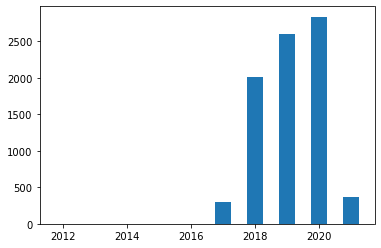

In [73]:
dates = UShousing1[['start_date']].dropna()
dates = pd.to_datetime(dates['start_date'],format = '%Y-%m-%d')
dates = dates.to_frame()
dates_cleaned = dates[dates.start_date < pd.to_datetime('2021-12-31',format = '%Y-%m-%d')]
# dates_cleaned.describe()
dates_cleaned['year'] = pd.DatetimeIndex(dates_cleaned['start_date']).year
# dates_cleaned['year'].plot.hist(color = 'green',alpha = 0.8)
# dates_cleaned['year'].plot.hist(color = 'green',alpha = 0.8)
y = dates_cleaned.groupby(['year']).count()['start_date']
arr = plt.bar(x = y.index,height=y, width=0.5, label = True)



##### Location

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentExcept

IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearR

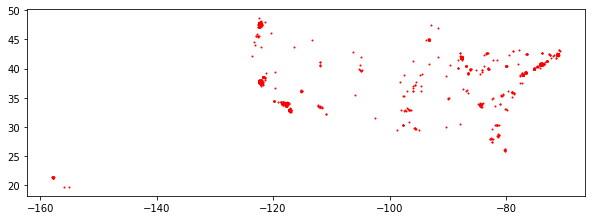

In [74]:
# https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6
geometry = [Point(xy) for xy in zip(UShousing1['longitude'], UShousing1['latitude'])]
gdf = GeoDataFrame(UShousing1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=1);



Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not

ValueError: Axis limits cannot be NaN or Inf

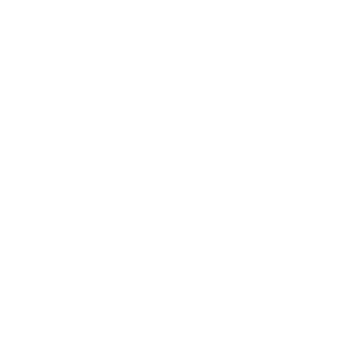

In [75]:
# https://residentmario.github.io/geoplot/quickstart/quickstart.html
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
# gplt.polyplot(contiguous_usa)
ax = gplt.polyplot(contiguous_usa)
gplt.pointplot(gdf, ax=ax)


##### Correlation analysis

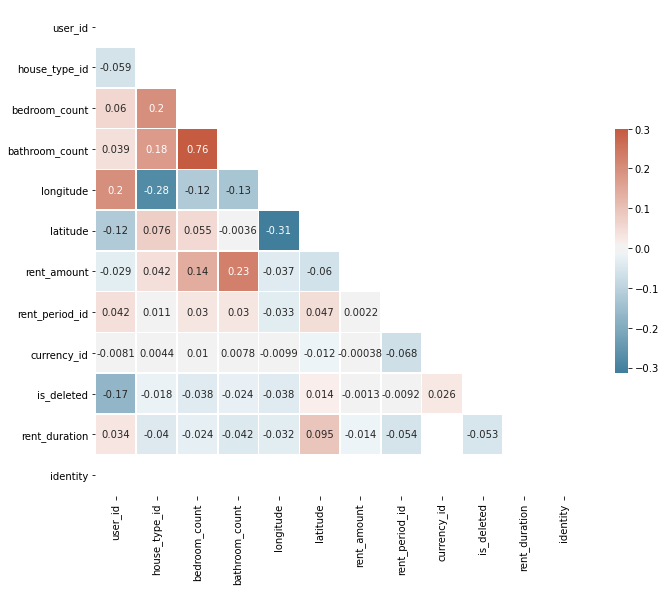

In [76]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = UShousing1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

##### Prediction distribution

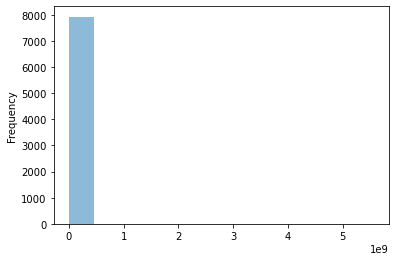

In [77]:
UShousing1["rent_amount"].plot.hist(bins=12, alpha=0.5)

Delete outliers for rent amount

In [78]:
UShousing1 = UShousing1[UShousing1.rent_amount < 30000]

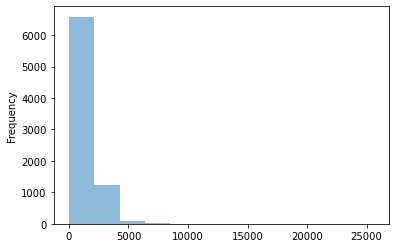

In [79]:
UShousing1["rent_amount"].plot.hist(bins=12, alpha=0.5)

Distribution based on different features

In [80]:
numdf = UShousing1.select_dtypes(include=[np.number])
num_cols = numdf.columns
num_cols

Index(['user_id', 'house_type_id', 'bedroom_count', 'bathroom_count',
       'longitude', 'latitude', 'rent_amount', 'rent_period_id', 'currency_id',
       'is_deleted', 'rent_duration', 'identity'],
      dtype='object')

house_type_id


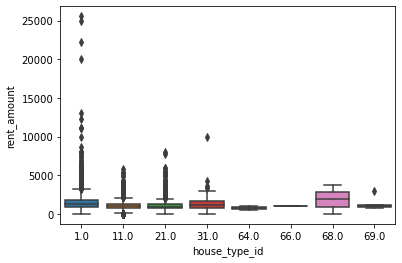

In [81]:
#Provide some examples due to time limit
for col in num_cols[1:2]:
    print(col)
    sns.boxplot(x=col, y="rent_amount", data=UShousing1)
    plt.show()

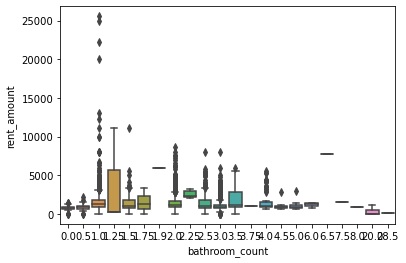

In [82]:
sns.boxplot(x="bathroom_count", y="rent_amount", data=UShousing1)
# plt.figure(figsize=(,100))
plt.show()

In [83]:
cols = UShousing1.columns

cate_cols = list(set(cols) - set(num_cols))
cate_cols

['rent_flag',
 'Country_geo',
 'is_published',
 'is_shared',
 'timezone',
 'is_blocked',
 'geometry',
 'description_falg',
 'facility_flag',
 'weight',
 'is_banner',
 'start_date',
 'base_info_flag',
 'agent_flag',
 'publisher_identity',
 'City_geo',
 'update_time',
 'State_geo',
 'language',
 'create_time',
 'Postcode_geo',
 'map_type',
 'update_utc_time']

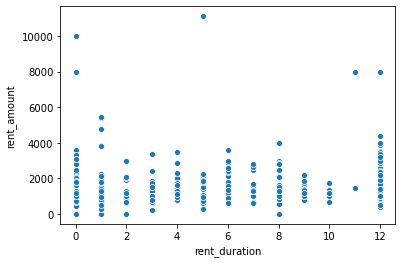

In [84]:
sns.scatterplot(x="rent_duration", y="rent_amount", data=UShousing1)
plt.show()

# Part 2 Further data pre-processing after EDA

## 1, Data Selection and Modification

##### Understanding the house_type_id

In [85]:
UShousing1['house_type_id'].unique()

array([ 1., 21., 31., 11., 69., 64., 66., 68.])

In [86]:
# Replace house type number to character
UShousing1['house_type_id'] = UShousing1['house_type_id'].astype(str)
UShousing1['house_type_id'] = UShousing1['house_type_id'].map({'1.0': 'Apartment',
                                                               '11.0': 'Townhouse',
                                                               '21.0': 'House',
                                                               '31.0': 'Other',
                                                               '64.0': 'Apartment',
                                                               '65.0': 'House',
                                                               '66.0': 'Townhouse',
                                                               '67.0': 'Other',
                                                               '68.0': 'Entire_house',
                                                               '68.0': 'Private_bedroom',
                                                               '70.0': 'Shared_bedroom',
                                                               '71.0': 'Entire_property',
                                                               '78.0': 'Shared_living'})
UShousing1

,user_id,house_type_id,bedroom_count,bathroom_count,longitude,latitude,start_date,rent_amount,rent_period_id,currency_id,...,map_type,publisher_identity,rent_duration,language,identity,Country_geo,City_geo,State_geo,Postcode_geo,geometry
0,41,Apartment,1.0,1.0,-73.857997,40.862775,2017-09-25,1500.0,2.0,1.0,...,1,0,NaN,NaN,0.0,United States,New York,New York,10467.0,POINT (-73.85800 40.86278)
1,41,Apartment,1.0,1.0,-73.827866,40.693742,2017-09-25,900.0,2.0,1.0,...,1,0,NaN,NaN,0.0,United States,New York,New York,11419.0,POINT (-73.82787 40.69374)
2,41,Apartment,1.0,1.0,-73.951277,40.780365,2017-09-25,45.0,1.0,1.0,...,1,0,NaN,NaN,0.0,United States,New York,New York,10128.0,POINT (-73.95128 40.78036)
3,41,House,2.0,1.0,-122.269401,47.848989,2017-10-01,2040.0,2.0,1.0,...,1,0,NaN,NaN,0.0,United States,Lynnwood,Washington,98087.0,POINT (-122.26940 47.84899)
4,41,Apartment,1.0,1.0,-122.356307,47.647601,2017-10-01,1000.0,2.0,1.0,...,1,0,NaN,NaN,0.0,United States,Seattle,Washington,98109.0,POINT (-122.35631 47.64760)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8198,246542,Apartment,2.0,1.0,-71.067466,42.431090,2021-03-01,1950.0,2.0,1.0,...,1,0,NaN,zh,0.0,United States,Malden,Massachusetts,02176-6104,POINT (-71.06747 42.43109)
8199,186472,Townhouse,1.0,1.0,-122.312883,47.589051,2021-03-31,1300.0,2.0,1.0,...,1,NaN,NaN,zh,0.0,United States,Seattle,Washington,98144,POINT (-122.31288 47.58905)
8200,325971,House,4.0,3.0,-122.257076,47.861079,2021-02-21,600.0,2.0,1.0,...,1,1,6.0,zh,0.0,United States,Lynnwood,Washington,98087,POINT (-122.25708 47.86108)
8204,262092,Apartment,2.0,1.0,-73.820328,40.762538,2021-02-21,1800.0,2.0,1.0,...,1,0,0.0,en,0.0,United States,New York,New York,11354,POINT (-73.82033 40.76254)


In [87]:
# UShousing1.groupby('State_geo')['rent_amount'].mean()

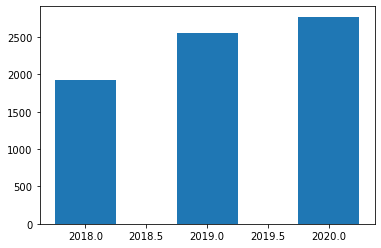

In [88]:
# Choose data from 2018 to 2020
open_date = '2018-01-01'
close_date = '2020-12-31'
con1 = UShousing1['start_date'] >= open_date
con2 = UShousing1['start_date'] <= close_date
UShousing1 = UShousing1[con1 & con2]


dates = UShousing1[['start_date']].dropna()
dates = pd.to_datetime(dates['start_date'],format = '%Y-%m-%d')
dates = dates.to_frame()
dates_cleaned = dates[dates.start_date < pd.to_datetime('2021-12-31',format = '%Y-%m-%d')]
dates_cleaned.describe()
dates_cleaned['year'] = pd.DatetimeIndex(dates_cleaned['start_date']).year
# dates_cleaned['year'].plot.hist(color = 'green',alpha = 0.8)
y = dates_cleaned.groupby(['year']).count()['start_date']
arr = plt.bar(x = [2018,2019,2020],height=y, width=0.5, label = True)


In [89]:
# Make sure the weird spots are Hawaii
# UShousing1.loc[UShousing1['State_geo'] == 'Hawaii', ['latitude', 'longitude', 'rent_amount']]

In [90]:
UShousing1['rent_period_id'] = UShousing1['rent_period_id'].astype(str)
UShousing1['currency_id'] = UShousing1['currency_id'].astype(str)
UShousing1['is_deleted'] = UShousing1['is_deleted'].astype(str)
UShousing1['identity'] = UShousing1['identity'].astype(str)

##### Missing value analysis - whether they are randomly missing

In [91]:
# Categorical columns selected
cat_df = UShousing1.select_dtypes(include = 'object')
# Check Radnomly Missing or not
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
# confusion_matrix = pd.crosstab(UShousing1['start_date'], UShousing1['start_date'])
# cramers_corrected_stat(confusion_matrix)

c_list = []
for c1 in cat_df:
    for c2 in cat_df:
#         print(c1, c2)
        confusion_matrix = pd.crosstab(UShousing1[c1], UShousing1[c2])
        c_value = cramers_corrected_stat(confusion_matrix)
        print(c1, c2, c_value)
        c_list.append([c1, c2, c_value])
        
c_df = pd.DataFrame(c_list, columns=['c1', 'c2', 'c_value'])


house_type_id house_type_id 0.9999999999999999
house_type_id start_date 0.19921895224224054
house_type_id rent_period_id 0.019588434596423985
house_type_id currency_id 0.0007290357218626345
house_type_id is_blocked 0.0
house_type_id is_published 0.025014241258876246
house_type_id is_banner 0.0
house_type_id weight 0.005305578827162142
house_type_id is_shared 0.0104147526372857
house_type_id base_info_flag 0.08785670471405196
house_type_id rent_flag 0.046374783572855155
house_type_id facility_flag 0.044726016645375954
house_type_id description_falg 0.0
house_type_id agent_flag 0.0
house_type_id is_deleted 0.014886559398807103
house_type_id create_time 0.11941525350193966
house_type_id update_time 0.10718898969920072
house_type_id update_utc_time 0.12837483983431935
house_type_id timezone 0.19081764444453303
house_type_id map_type 0.010388602798376763
house_type_id publisher_identity 0.024456021607340245
house_type_id language 0.07155707088935108
house_type_id identity 0.0
house_type_id 

is_shared City_geo 0.08111301929291903
is_shared State_geo 0.17376626666617195
is_shared Postcode_geo 0.610238013187343
base_info_flag house_type_id 0.08785670471405198
base_info_flag start_date 0.5802955977112093
base_info_flag rent_period_id 0.030623770064944128
base_info_flag currency_id 0.02730824140078368
base_info_flag is_blocked 0.0356627162853155
base_info_flag is_published 0.10490399898810485
base_info_flag is_banner 0.02070196863259299
base_info_flag weight 0.04761584528789317
base_info_flag is_shared nan
base_info_flag base_info_flag 0.998593607115357
base_info_flag rent_flag 0.7576489767147597
base_info_flag facility_flag 0.8116378909506576
base_info_flag description_falg 0.5372516708851159
base_info_flag agent_flag 0.0
base_info_flag is_deleted 0.17426102301470564
base_info_flag create_time 0.0900936033328705
base_info_flag update_time 0.1071222814738634
base_info_flag update_utc_time 0.1283150053683188
base_info_flag timezone 0.18318601906514453
base_info_flag map_type 0.

update_time agent_flag 0.10712228147385977
update_time is_deleted 0.10713709476045397
update_time create_time 0.9374586665930074
update_time update_time 0.9999999999996785
update_time update_utc_time 0.9998421094171133
update_time timezone 0.10474325724861448
update_time map_type nan
update_time publisher_identity 0.0934850041878324
update_time language 0.11548643605462632
update_time identity 0.10712228147386185
update_time Country_geo nan
update_time City_geo 0.2294241087892025
update_time State_geo 0.10740478919574357
update_time Postcode_geo 0.35645958013497836
update_utc_time house_type_id 0.12837483983432108
update_utc_time start_date 0.36795886465850314
update_utc_time rent_period_id 0.12835488571282969
update_utc_time currency_id 0.0
update_utc_time is_blocked 0.1283150053683197
update_utc_time is_published 0.1463357147593886
update_utc_time is_banner nan
update_utc_time weight 0.12833494089323888
update_utc_time is_shared nan
update_utc_time base_info_flag 0.12831500536831839


City_geo Postcode_geo 0.8632767827872869
State_geo house_type_id 0.19798901757725126
State_geo start_date 0.11278182662172678
State_geo rent_period_id 0.05523833921070404
State_geo currency_id 0.17430296476848875
State_geo is_blocked 0.114697109955516
State_geo is_published 0.14475135378344942
State_geo is_banner 0.0
State_geo weight 0.0
State_geo is_shared 0.17376626666617195
State_geo base_info_flag 0.24439740265597734
State_geo rent_flag 0.2060695427893679
State_geo facility_flag 0.1520089162795573
State_geo description_falg 0.17643157329510417
State_geo agent_flag 0.0
State_geo is_deleted 0.0870784931313766
State_geo create_time 0.11965570105327641
State_geo update_time 0.10740478919574357
State_geo update_utc_time 0.12899807112816822
State_geo timezone 0.9410186381243967
State_geo map_type 0.29224226464563524
State_geo publisher_identity 0.21357513993905225
State_geo language 0.3639103330127401
State_geo identity 0.046104128866568665
State_geo Country_geo nan
State_geo City_geo 0.

In [92]:
c_df[c_df.c_value > 0.3]

,c1,c2,c_value
0,house_type_id,house_type_id,1.000000
26,house_type_id,Postcode_geo,0.411079
28,start_date,start_date,1.000000
31,start_date,is_blocked,0.618503
35,start_date,is_shared,0.923685
...,...,...,...
722,Postcode_geo,publisher_identity,0.551628
723,Postcode_geo,language,0.572993
726,Postcode_geo,City_geo,0.863277
727,Postcode_geo,State_geo,0.920121


## 2, Filling missing values with proper data

In [93]:
# Mode Imputation for missing values in Categorical Var Columns
cat_df.isna().sum()

house_type_id            6
start_date               0
rent_period_id           0
currency_id              0
is_blocked              17
is_published          4758
is_banner               16
weight                  16
is_shared               15
base_info_flag          14
rent_flag               15
facility_flag           12
description_falg        13
agent_flag              12
is_deleted               0
create_time             17
update_time             16
update_utc_time       4030
timezone              2318
map_type                14
publisher_identity     494
language              3725
identity                 0
Country_geo              0
City_geo                 1
State_geo                0
Postcode_geo             1
dtype: int64

In [94]:
cat_df_col = cat_df.columns.values.tolist()

In [95]:
cat_df[cat_df['City_geo'].isna()]
# Chino Hills
UShousing1['City_geo'] = UShousing1['City_geo'].fillna('Chino Hills')

In [96]:
cat_df[cat_df['Postcode_geo'].isna()]
# It is Toronto, not in US so drop it
UShousing1 = UShousing1[UShousing1['Postcode_geo'].notna()]

In [97]:
cat_df_col.remove('Country_geo')
cat_df_col.remove('City_geo')
cat_df_col.remove('State_geo')
cat_df_col.remove('Postcode_geo')

In [98]:
for c in cat_df_col:
    UShousing1[c].fillna(UShousing1[c].mode()[0], inplace=True) 

In [99]:
UShousing1.isna().sum()

user_id                  0
house_type_id            0
bedroom_count            0
bathroom_count           0
longitude                0
latitude                 0
start_date               0
rent_amount              0
rent_period_id           0
currency_id              0
is_blocked               0
is_published             0
is_banner                0
weight                   0
is_shared                0
base_info_flag           0
rent_flag                0
facility_flag            0
description_falg         0
agent_flag               0
is_deleted               0
create_time              0
update_time              0
update_utc_time          0
timezone                 0
map_type                 0
publisher_identity       0
rent_duration         6973
language                 0
identity                 0
Country_geo              0
City_geo                 0
State_geo                0
Postcode_geo             0
geometry                 0
dtype: int64

In [100]:
# Mean Imputation for Missing values in Continuous Var Columns
con_df = UShousing1.select_dtypes(include = 'float')

In [101]:
con_df.isna().sum()

bedroom_count        0
bathroom_count       0
longitude            0
latitude             0
rent_amount          0
rent_duration     6973
dtype: int64

In [102]:
for c in con_df:
    UShousing1[c].fillna(UShousing1[c].mean(), inplace=True) 

In [103]:
UShousing1.isna().sum()

user_id               0
house_type_id         0
bedroom_count         0
bathroom_count        0
longitude             0
latitude              0
start_date            0
rent_amount           0
rent_period_id        0
currency_id           0
is_blocked            0
is_published          0
is_banner             0
weight                0
is_shared             0
base_info_flag        0
rent_flag             0
facility_flag         0
description_falg      0
agent_flag            0
is_deleted            0
create_time           0
update_time           0
update_utc_time       0
timezone              0
map_type              0
publisher_identity    0
rent_duration         0
language              0
identity              0
Country_geo           0
City_geo              0
State_geo             0
Postcode_geo          0
geometry              0
dtype: int64

In [104]:
# Only keep pulished listings
UShousing1 = UShousing1[UShousing1.is_published == '1']

In [105]:
drop_cols = ['is_published','user_id','longitude','latitude',
'rent_period_id','currency_id','is_deleted','is_blocked',
'is_banner','weight','is_shared','base_info_flag',        
'rent_flag', 'facility_flag','description_falg','agent_flag',
'map_type','language','timezone','create_time','update_time',
'update_utc_time','Country_geo']
UShousing2 = UShousing1.drop(drop_cols,axis=1)

In [106]:
# UShousing2.to_csv('UShouing_info.csv', index=False)  

##### due to time issue, we just save the data we have and upload it again

In [107]:
UShousing2 = pd.read_csv('UShousing_info.csv')

In [108]:
# data modification after upload
#convert start_date to datetime
UShousing2['start_date'] = pd.to_datetime(UShousing2['start_date'],format = '%Y-%m-%d')

#extract year and save as a new column
UShousing2['year'] = pd.DatetimeIndex(UShousing2['start_date']).year
UShousing2['year'] = UShousing2['year'].astype('object')
UShousing2['year']= UShousing2['year'].astype('category')
UShousing2.drop('start_date',axis=1,inplace = True)
UShousing2.loc[UShousing2['publisher_identity']== 'America/New_York','publisher_identity'] = '0'
UShousing2.loc[UShousing2['publisher_identity']== 'America/Los_Angeles','publisher_identity'] = '0'
UShousing2['identity'].unique()
UShousing2['identity']= UShousing2['identity'].fillna(0)
# UShousing2.drop('identity',axis=1,inplace = True)

# Part 3 Modeling

In [109]:
UShousing2.head()

,house_type_id,bedroom_count,bathroom_count,rent_amount,publisher_identity,rent_duration,identity,City_geo,State_geo,Postcode_geo,year
0,Townhouse,3.0,3.0,1000.0,0,5.826715,0.0,Seattle,Washington,98133,2020
1,Apartment,1.0,1.0,1576.0,0,5.826715,0.0,Philadelphia,Pennsylvania,19104-2989,2018
2,Apartment,2.0,1.0,1200.0,0,5.826715,0.0,Seattle,Washington,98109,2019
3,Townhouse,1.0,1.0,950.0,0,5.826715,0.0,Seattle,Washington,98117,2019
4,Apartment,1.0,1.0,1000.0,0,5.826715,0.0,New York,New York,10027,2018


In [110]:
UShousing3 = UShousing2.copy()
X = UShousing3.drop('rent_amount',axis=1)
y = UShousing2['rent_amount']
X.shape, y.shape

((6383, 10), (6383,))

# 1, Feature Engineering

1. Convert categorical features to numerics
2. Standardize Numerical features

In [111]:
UShousing2 = UShousing2[UShousing2['rent_amount'] > 0]
xreg = pd.get_dummies(data=X[X.columns.difference(["identity"])])

## 2, Model implement

##### Split Training set & Testing set

In [112]:
X_train, X_test, y_train, y_test = train_test_split(xreg, y, test_size=0.3, random_state= 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4468, 1302), (1915, 1302), (4468,), (1915,))

In [113]:
X_train.shape

(4468, 1302)

In [114]:
numerics = ['int64','float64']

train_num = X_train.select_dtypes(include=numerics)
test_num =  X_test[train_num.columns]


scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(train_num),columns = train_num.columns)
x_test_scaled = pd.DataFrame(scaler.transform(test_num), columns = test_num.columns)

x_train_scaled.shape,x_test_scaled.shape
x_train_scaled.head()



,bathroom_count,bedroom_count,rent_duration
0,-0.638320,0.057880,-0.013735
1,0.701282,0.772273,-0.013735
2,-0.638320,-0.656512,-0.013735
3,-0.638320,-0.656512,-0.013735
4,1.371084,0.057880,-0.013735


In [115]:
X_train.loc[:,'bathroom_count'] = x_train_scaled.loc[:,'bathroom_count'].values
X_train.loc[:,'bedroom_count'] = x_train_scaled.loc[:,'bedroom_count'].values
X_train.loc[:,'rent_duration'] = x_train_scaled.loc[:,'rent_duration'].values
X_test.loc[:,'bathroom_count'] = x_test_scaled.loc[:,'bathroom_count'].values
X_test.loc[:,'bedroom_count'] = x_test_scaled.loc[:,'bedroom_count'].values
X_test.loc[:,'rent_duration'] = x_test_scaled.loc[:,'rent_duration'].values

In [136]:
# simple linear regression 
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
# reg.predict(X_test)
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    # median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    #print('explained_variance: ', round(explained_variance,4))    
    # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    #print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    #print('RMSE: ', round(np.sqrt(mse),4))
regression_results(y_test,reg.predict(X_test))

MAE:  69468072224802.81
MSE:  2.665737692311943e+29


In [117]:
## Linear regression with regularization - Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn import linear_model
from statistics import mean
alphas = [0.05,0.1,0.15,0.2,0.25]
kf = KFold(3, shuffle=True, random_state=0)
cross_val_list = []

for i in alphas:
    rm2b1 = linear_model.Lasso(alpha=i, fit_intercept = True,max_iter=5000, normalize=True)
    cross_val_list.append(sum(cross_val_score(rm2b1, X_train, y_train, cv=kf)) / 4)

alpha_best_cv = alphas[cross_val_list.index(max(cross_val_list))]
rm2a3 = linear_model.Lasso(alpha=0.21, fit_intercept = True)
lasso_model_2a3 = rm2a3.fit(X_train, y_train)
ytest_pred_2a3 = rm2a3.predict(X_test)
print('MAE: ',  metrics.mean_absolute_error(y_test, ytest_pred_2a3))
print('MSE: ',  metrics.mean_squared_error(y_test, ytest_pred_2a3))

MAE:  588.2756756473639
MSE:  974087.8166520796


In [118]:
# Decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
grid_values = {'ccp_alpha': np.linspace(0, 0.1, 21), 'min_samples_split':[2,10,50,100]}
dtc = DecisionTreeRegressor(random_state=88)
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, cv=5, n_jobs=-1).fit(X_train, y_train)
y_pred = dtc_cv.predict(X_test)
print('MAE: ',  metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ',  metrics.mean_squared_error(y_test, y_pred))

MAE:  602.1786674096901
MSE:  1059696.0599883192


In [119]:
# AdaBoost
# ! pip install xgboost
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate =0.005)
regr.fit(X_train, y_train)

y_pred_adaboost = regr.predict(X_test)
print('MAE: ',  metrics.mean_absolute_error(y_test, y_pred_adaboost))
print('MSE: ',  metrics.mean_squared_error(y_test, y_pred_adaboost ))

MAE:  656.5378290142426
MSE:  1113584.4306223344


In [120]:
# XGboost
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred_xgboost = model.predict(X_test)
print('MAE: ',  metrics.mean_absolute_error(y_test, y_pred_xgboost))
print('MSE: ',  metrics.mean_squared_error(y_test, y_pred_xgboost))

MAE:  579.1354494396239
MSE:  951404.0942408409


In [121]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(
    max_depth=10000,
    n_estimators=5,
    learning_rate=0.1
)
regressor.fit(X_train, y_train)
errors = [metrics.mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)] 
best_n_estimators = np.argmin(errors)

best_regressor = GradientBoostingRegressor(
    max_depth=10000,
    n_estimators=best_n_estimators,
    learning_rate=0.1
)
best_regfit = best_regressor.fit(X_train, y_train)
y_pred = best_regressor.predict(X_test)


print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))

MAE: 622.7985956476914
MSE: 855505.2993144775


In [122]:
from tensorflow import keras
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.backend import clear_session
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import resample
from sklearn.model_selection import train_test_split


# We disable tensorflow eager execution mode to enhance CPU and RAM efficiency
disable_eager_execution()

## Stratified Sampling
#X_train_sample, y_train_sample = resample(X_train,y_train,
#                                          replace=False,n_samples=4000,random_state=0)
## Trainv-validation split 
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=0)

#initializer_G = keras.initializers.GlorotNormal(seed=0)
clear_session()
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[1302]),
  keras.layers.Dense(units=200, kernel_initializer='normal', activation='relu'),
  keras.layers.Dense(units=200, kernel_initializer='normal', activation='relu'),
  keras.layers.Dense(units=1, kernel_initializer='normal', activation='relu')
])
model.compile(optimizer='adam', loss='mean_absolute_error',
              metrics=["mean_absolute_error"])


history = model.fit(X_train,y_train,validation_data=(X_val,y_val),
                        batch_size=32,epochs=10,shuffle=False,verbose=0)
y_pred_raw = model.predict(X_test)
y_pred_nn = y_pred_raw.reshape(1,-1)[0]
print('MAE:',metrics.mean_absolute_error(y_test, y_pred_nn))
print('MSE:',metrics.mean_squared_error(y_test, y_pred_nn))

MAE: 551.028459719028
MSE: 830322.7315191792


# Part 4 UI
Use Pickle and Flask for web-based application 

In [123]:
# !pip install mlxtend

# Try the Pickle here 

In [125]:
# The 6 features selected 
Xx = X_train.loc[:,('bathroom_count',
 'bedroom_count',
 'City_geo_New York',
 'Postcode_geo_10019',
 'Postcode_geo_10107',
 'house_type_id_Apartment')]

from sklearn.ensemble import GradientBoostingRegressor
result =GradientBoostingRegressor(
    max_depth=10000,
    n_estimators=best_n_estimators,
    learning_rate=0.1).fit(Xx,y_train)


In [126]:
import pickle
from flask import Flask, request, render_template
# Since we have already provided model.pkl in the submission folder, we commented out this part 
with open('model.pkl', 'wb') as file:
    pickle.dump(result, file)

In [127]:
# Create application
app = Flask(__name__)

In [128]:
model = pickle.load(open('model.pkl', 'rb'))

In [129]:
uix = X_test.loc[:,['bathroom_count',
 'bedroom_count',
 'City_geo_New York',
 'Postcode_geo_10019',
 'Postcode_geo_10107',
 'house_type_id_Apartment']]

In [130]:
[uix.iloc[0,:]]

[bathroom_count             1.371084
 bedroom_count              0.057880
 City_geo_New York          0.000000
 Postcode_geo_10019         0.000000
 Postcode_geo_10107         0.000000
 house_type_id_Apartment    0.000000
 Name: 1153, dtype: float64]

In [131]:
# Try if the model is stored properly
print(model.predict([uix.iloc[0,:]]))

[1512.9879164]


Flask starts here

In [132]:
# Bind home function to URL
@app.route('/')
def home():
    return render_template('Rent Prediction.html')

@app.route('/predict',methods=['POST'])
def predict():
    #For rendering results on HTML GUI
    int_features = [float(x) for x in request.form.values()]
    final_features = [np.array(int_features)]
    prediction = model.predict(final_features)
    output = round(prediction[0], 2) 
    return render_template('Rent Prediction.html', prediction_text='Rent estimated for this property is :{}'.format(output))

In [133]:
#skip
# html file 
'''
text = 
<html>
    <div class = 'login'>
        <h1>Predict Rent price</h1>
         <h3>Enter the following value to predict the rent price </h3>
     
        <form action = "{{ url_for("predict")}}"method = "post">
            <input type = "text" name = "bathroomcount" placeholder = "Bathroom Count" required = "required" />
            <input type = "text" name = "bedroomcount" placeholder = "Bedroom Count" required = "required" />
            <input type = "text" name = "cityNY" placeholder = "citisNY" required = "required" />
            <input type = "text" name = "Post10019" placeholder = "postis10019" required = "required" />
            <input type = "text" name = "Post10107" placeholder = "Post10107" required = "required" />
            <input type = "text" name = "Housetype" placeholder = "House Type" required = "required" />

            <button type = "submit" class = "btn">predict</button>
        </form>
 
      <br>
      <br>
      {{ prediction_text }}
  
    </div>
<html>
'''

'''
# save the html file
file = open("Rent Prediction.html","w")
file.write(text)
file.close()
'''

'\n# save the html file\nfile = open("Rent Prediction.html","w")\nfile.write(text)\nfile.close()\n'

In [134]:
# run this cell for the first time
#!pip install flask==0.12.2

In [ ]:
if __name__ == "__main__":
    app.run(debug=True,use_reloader = False,port=4996,host="0.0.0.0")

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:4996/ (Press CTRL+C to quit)
127.0.0.1 - - [06/May/2021 15:51:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2021 15:51:16] "POST /predict HTTP/1.1" 200 -


In [ ]:
# If the above code doesn't work. Trouble shooting by following cells

In [ ]:
#! conda install nodejs --yes

In [ ]:
#! jupyter nbextension enable --py --sys-prefix widgetsnbextension

# Tryout ends here 